In [1]:
from src.utils import poses_from_vicon, set_axes_equal
import matplotlib.pyplot as plt
import h5py
import numpy as np
np.set_printoptions(precision=3, suppress=True)
%matplotlib widget

from scipy.signal import resample_poly
from scipy.spatial.transform import Rotation as R

import cv2
import mediapy

### Read Device Data

In [2]:
f = h5py.File("/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing/episode_20240620_143106.h5",'r')
poses = np.array(f['pose_values'])
print(len(poses))
pose_confidences = np.array(f['pose_confidences'])
translations = np.array([pose[:3, 3] for pose in poses])
orientations = np.array([pose[:3, :3] for pose in poses])

720


### Read and Synchronize Vicon Data

In [3]:
vicon_poses = poses_from_vicon("/Users/jannik/Repos/demonstration-interface/data/session_20240620_142739_smoothing/Trial7.csv")

# Resample the data using rational resampling
up = 3   # Upsampling factor
down = 10  # Downsampling factor (100 / 30 = 3.33; 10/3 ≈ 3.33)
vicon_poses_downsampled = resample_poly(vicon_poses, up, down)
start_idx = 20
vicon_poses_downsampled = vicon_poses_downsampled[start_idx:start_idx+len(poses)]
print(len(vicon_poses_downsampled))

720


### Video Stream

In [4]:
color_images = np.array(f['color_images'])
color_images = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in color_images])
mediapy.show_video(color_images, fps=30)

### Pose Alignment & Error Calculation

In [5]:
def compute_transformation_matrix(estimated_poses, ground_truth_poses):
    assert estimated_poses.shape == ground_truth_poses.shape
    N = estimated_poses.shape[0]

    # Extract translation components
    t_estimated = estimated_poses[:, :3, 3]
    t_ground_truth = ground_truth_poses[:, :3, 3]

    # Extract rotation components
    R_estimated = estimated_poses[:, :3, :3]
    R_ground_truth = ground_truth_poses[:, :3, :3]

    # Compute centroids
    centroid_t_estimated = np.mean(t_estimated, axis=0)
    centroid_t_ground_truth = np.mean(t_ground_truth, axis=0)

    # Center the data
    t_estimated_centered = t_estimated - centroid_t_estimated
    t_ground_truth_centered = t_ground_truth - centroid_t_ground_truth

    # Compute H matrix
    H = t_estimated_centered.T @ t_ground_truth_centered

    # SVD
    U, S, Vt = np.linalg.svd(H)
    R_optimal = Vt.T @ U.T

    if np.linalg.det(R_optimal) < 0:
        Vt[-1, :] *= -1
        R_optimal = Vt.T @ U.T

    t_optimal = centroid_t_ground_truth - R_optimal @ centroid_t_estimated

    return R_optimal, t_optimal

def apply_transformation(estimated_poses, R_optimal, t_optimal):
    N = estimated_poses.shape[0]
    transformed_poses = np.zeros_like(estimated_poses)
    
    for i in range(N):
        # Apply rotation
        transformed_poses[i, :3, :3] = R_optimal @ estimated_poses[i, :3, :3]
        # Apply translation
        transformed_poses[i, :3, 3] = R_optimal @ estimated_poses[i, :3, 3] + t_optimal
        # Homogeneous component remains 1
        transformed_poses[i, 3, 3] = 1.0

    return transformed_poses

def compute_ate(estimated_poses, ground_truth_poses):
    # Calculate the Euclidean distance between corresponding positions
    differences = estimated_poses[:, :3, 3] - ground_truth_poses[:, :3, 3]
    squared_differences = np.square(differences)
    sum_squared_differences = np.sum(squared_differences, axis=1)
    ate = np.sqrt(sum_squared_differences).mean()
    return ate

In [6]:
R_optimal, t_optimal = compute_transformation_matrix(poses, vicon_poses_downsampled)
aligned_estimated_poses = apply_transformation(poses, R_optimal, t_optimal)

# Compute RMSE for translation components
rmse_translation = np.sqrt(np.mean((aligned_estimated_poses[:, :3, 3] - vicon_poses_downsampled[:, :3, 3])**2))
print(f'RMSE (Translation): {rmse_translation}')

# Compute ATE
ate = compute_ate(aligned_estimated_poses, vicon_poses_downsampled)
print(f'Absolute Trajectory Error (ATE): {ate}')

# Optionally, compute RMSE for rotation components
# Convert rotation matrices to quaternions for easier comparison
# def rotation_matrix_to_quaternion(R):
#     return R.from_matrix(R).as_quat()

# estimated_quaternions = np.array([rotation_matrix_to_quaternion(R) for R in aligned_estimated_poses[:, :3, :3]])
# ground_truth_quaternions = np.array([rotation_matrix_to_quaternion(R) for R in vicon_poses_downsampled[:, :3, :3]])

# rmse_rotation = np.sqrt(np.mean((estimated_quaternions - ground_truth_quaternions)**2))
# print(f'RMSE (Rotation): {rmse_rotation}')

RMSE (Translation): 0.025206453117888234
Absolute Trajectory Error (ATE): 0.03725912294120214


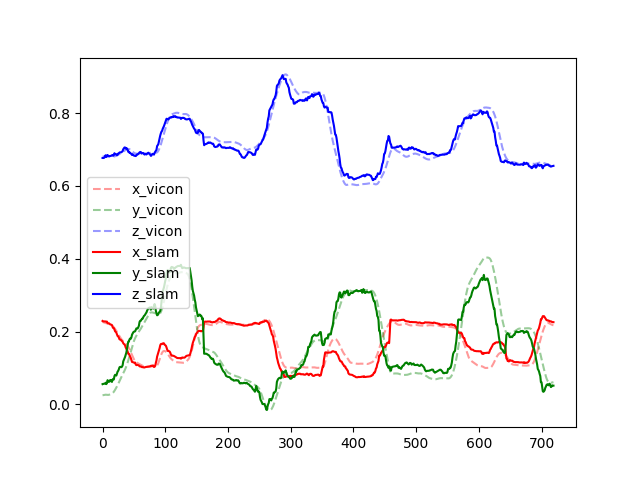

In [7]:
fig = plt.figure()
plt.plot(vicon_poses_downsampled[:,0,3], label="x_vicon", alpha=0.4, linestyle="dashed", color="r")
plt.plot(vicon_poses_downsampled[:,1,3], label="y_vicon", alpha=0.4, linestyle="dashed", color="g")
plt.plot(vicon_poses_downsampled[:,2,3], label="z_vicon", alpha=0.4, linestyle="dashed", color="b")
plt.plot(aligned_estimated_poses[:,0,3], label="x_slam", color="r")
plt.plot(aligned_estimated_poses[:,1,3], label="y_slam", color="g")
plt.plot(aligned_estimated_poses[:,2,3], label="z_slam", color="b")
plt.legend()
plt.show()

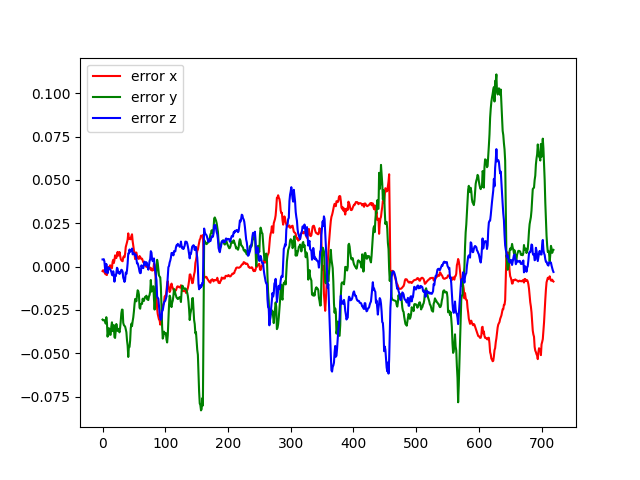

In [12]:
fig = plt.figure()
plt.plot(vicon_poses_downsampled[:,0,3]-aligned_estimated_poses[:,0,3], label="error x", color="r")
plt.plot(vicon_poses_downsampled[:,1,3]-aligned_estimated_poses[:,1,3], label="error y", color="g")
plt.plot(vicon_poses_downsampled[:,2,3]-aligned_estimated_poses[:,2,3], label="error z", color="b")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


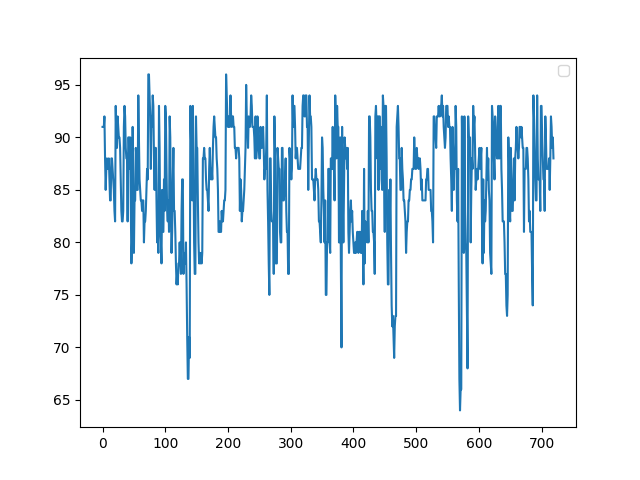

In [13]:
fig = plt.figure()
plt.plot(pose_confidences)
plt.legend()
plt.show()

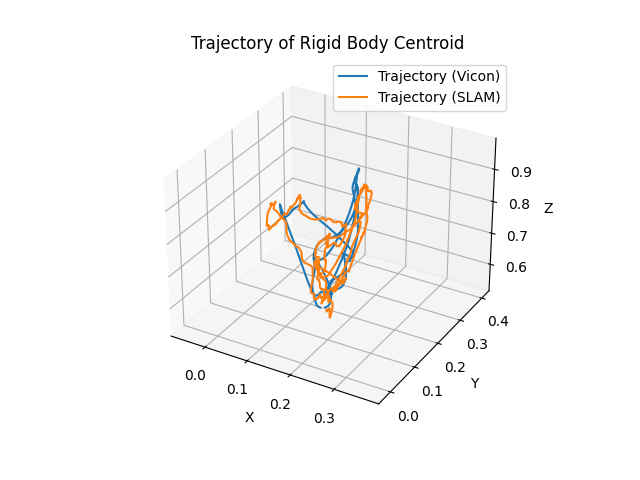

In [8]:
# Visualize the trajectory of the centroid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(vicon_poses_downsampled[:,0,3],vicon_poses_downsampled[:,1,3],vicon_poses_downsampled[:,2,3], label='Trajectory (Vicon)')
ax.plot(aligned_estimated_poses[:,0,3],aligned_estimated_poses[:,1,3],aligned_estimated_poses[:,2,3], label='Trajectory (SLAM)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)
ax.set_title('Trajectory of Rigid Body Centroid')
plt.legend()
plt.show()

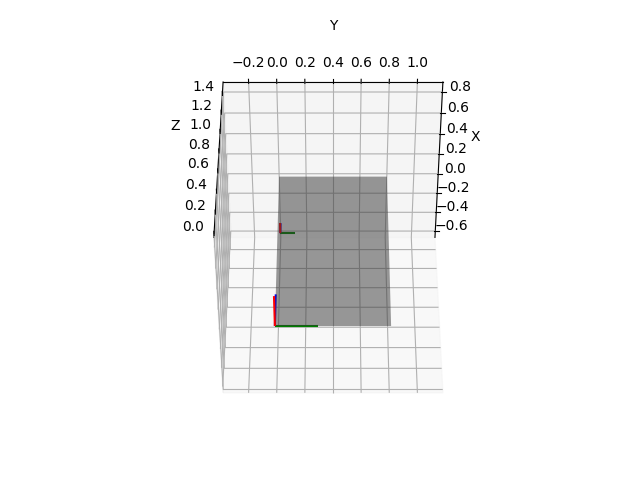

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')    
ax.set_box_aspect([1.0, 1.0, 1.0])


t = vicon_poses[0,:3, 3]
R = vicon_poses[0,:3, :3]
ax.quiver(t[0], t[1], t[2], R[0, 0], R[1, 0], R[2, 0], length=0.1, color='r', arrow_length_ratio=0)
ax.quiver(t[0], t[1], t[2], R[0, 1], R[1, 1], R[2, 1], length=0.1, color='g', arrow_length_ratio=0)
ax.quiver(t[0], t[1], t[2], R[0, 2], R[1, 2], R[2, 2], length=0.1, color='b', arrow_length_ratio=0)
ax.quiver(0,0,0, 1, 0, 0, length=0.3, color='r', arrow_length_ratio=0)
ax.quiver(0,0,0, 0,1,0, length=0.3, color='g', arrow_length_ratio=0)
ax.quiver(0,0,0, 0,0,1, length=0.3, color='b', arrow_length_ratio=0)

# Define the range for y and z
y = np.linspace(0, 0.8, 100)
z = np.linspace(0, 1.5, 100)
# Create a grid for y and z
Y, Z = np.meshgrid(y, z)
# Define x as a constant (e.g., x = 5)
X = np.full_like(Y, 0)

# Plot the plane
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, color='grey')

    
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
    
ax.grid(True)
ax.view_init(elev=-45, azim=0, roll=0)

set_axes_equal(ax)
plt.show()